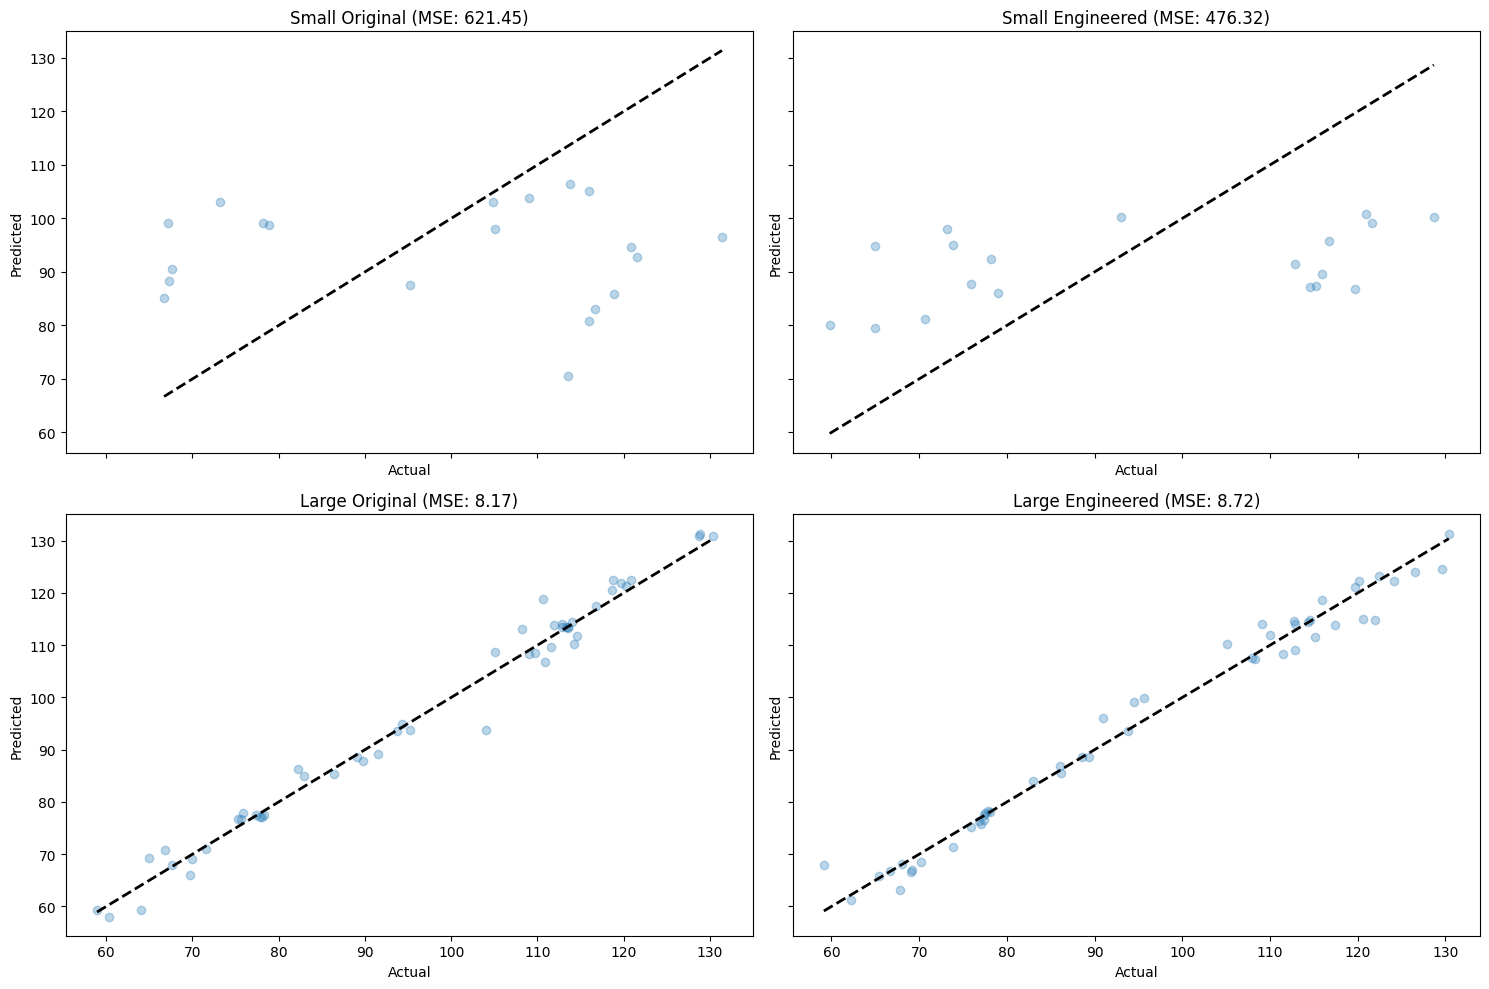

In [2]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from numpy import cumsum, where

# Function to calculate VWAP
def calculate_vwap(data):
    v = data['Volume'].values
    tp = (data['High'].values + data['Low'].values + data['Close'].values) / 3  # Typical price
    return cumsum(v * tp) / cumsum(v)

# Function to calculate OBV
def calculate_obv(data):
    obv = cumsum(where(data['Close'].values > data['Close'].shift(1).fillna(0).values, data['Volume'].values, 
                       where(data['Close'].values < data['Close'].shift(1).fillna(0).values, -data['Volume'].values, 0)))
    return obv

# Function to add engineered features to the dataset
def engineer_features(data):
    data['5_day_MA'] = data['Close'].rolling(window=5).mean()  # 5-day moving average
    data['daily_return'] = data['Close'].pct_change()          # Daily return
    data['VWAP'] = calculate_vwap(data)                        # Volume-Weighted Average Price
    data['OBV'] = calculate_obv(data)                          # On-Balance Volume
    return data.dropna()

# Function to compare the performance of models with and without feature engineering on different dataset sizes
def compare_models_on_datasets(ticker_symbol, start_date, end_date):
    stock = yf.Ticker(ticker_symbol)
    hist = stock.history(start=start_date, end=end_date)
    
    small_dataset = hist.sample(n=100)  # Small dataset
    large_dataset = hist                # Large dataset

    small_dataset_engineered = engineer_features(small_dataset.copy())
    large_dataset_engineered = engineer_features(large_dataset.copy())

    datasets = {
        'Small Original': small_dataset,
        'Small Engineered': small_dataset_engineered,
        'Large Original': large_dataset,
        'Large Engineered': large_dataset_engineered
    }
    results = {}

    for name, data in datasets.items():
        X = data[['Open', 'High', 'Low', 'Close', 'Volume']]
        y = data['Close'].shift(-1)  # Next day's closing price
        if 'Engineered' in name:
            # X = pd.concat([X, data[['5_day_MA', 'daily_return', 'VWAP', 'OBV']]], axis=1)
            X = pd.concat([X, data[['5_day_MA', 'OBV']]], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X[:-1], y.dropna(), test_size=0.2, random_state=0)

        model = RandomForestRegressor(random_state=0)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        results[name] = (y_test, pred, mse)

    fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex='col', sharey='row')

    for ax, (name, (y_test, pred, mse)) in zip(axs.flatten(), results.items()):
        ax.scatter(y_test, pred, alpha=0.3)
        ax.set_title(f'{name} (MSE: {mse:.2f})')
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predicted')
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

    plt.tight_layout()
    plt.show()

compare_models_on_datasets('AAPL', '2020-01-01', '2021-01-01')
